### Minimum Observations

In this simplest example, let's say you have a target consisting of a planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 580 cm/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case with a circular orbit and then generalize to include both AU Mic b and c. 

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils

1.22.3
1.7.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

#### White noise case

We begin by declaring our target planet's orbital parameters. Our covariance matrix in the white noise regime is simply a diagonal matrix of the photon noise. In their modeling of AU Mic b, Klein+ 2021 estimated that noise to be 500 cm/s. 

In [41]:
### target parameters
p = 8.5 # orbital period, days
K = 580 # cm/s
T0 = 2360 # arbitrarily chosen fiducial central transit time, in BJD

### white/photon noise
sigma_wn_rv = 5 * 1e2 # [cm/s]

### choose arbitrary start time
start = 2352

We must also choose an observing cadence. The base case here is an observation once per day, for a cadence (time between observations) of 1 day.

In [42]:
c = 1 # observing cadence of once per day

Finally, we declare the stellar noise parameters and populate the inputs into the covariance matrix and Fisher Information calculation functions.

In [ ]:
### observing parameters
sigma_ks = []

### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]

params = [Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

Okay! The only thing we've left unconstrained is the number of observations. We can vary them, building an increasingly longer time series of observations, each time recalculating the covariance matrix, Fisher Information, and uncertainty on the RV semi-amplitude.

In [39]:
for n_obs in tqdm(range(100)[4:]):
    
    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs, c, start, offs=[], dropout=0.)
    
    # build strategy aka time series of observations
    strat = strategy.gappy()

    # build covariance matrix, characterized by a correlated noise model of the stellar signal
    #sigma = np.diag(sigma_wn_rv * np.ones(len(strat)))
    sigma = calculate_fi.cov_matrix_jax(strat, params)
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma**2, jnp.array(theta, dtype=float)
    
    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
    
    # invert FI matrix
    inv_fim = inv(fim)
    
    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    
    sigma_ks.append(sigma_k)
    

  0%|                                                                                                        | 0/96 [00:00<?, ?it/s]/var/folders/h2/sp_lfvz5515bhg_y92psw7f80000gn/T/ipykernel_21673/659300973.py:44: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1729.04it/s]


In [40]:
min(sigma_ks)

71.31553

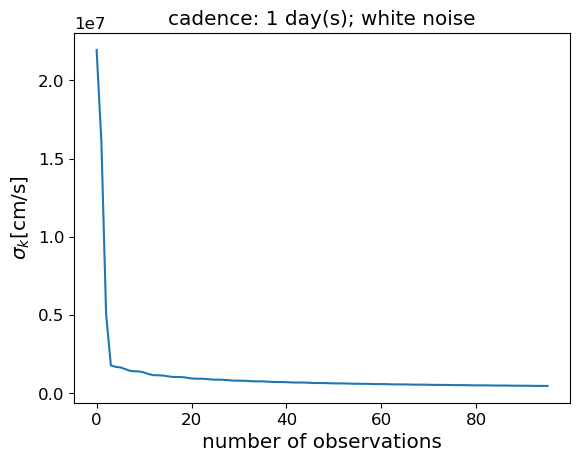

In [34]:
plt.plot(range(len(sigma_ks)), sigma_ks)
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {c} day(s); white noise")
#plt.savefig(path + f"plots/au-mic/n_obs.png", format="png")
#plt.ylim([0, 10*K])
plt.show()

#### Visualize what a good strategy is sampling in phase space

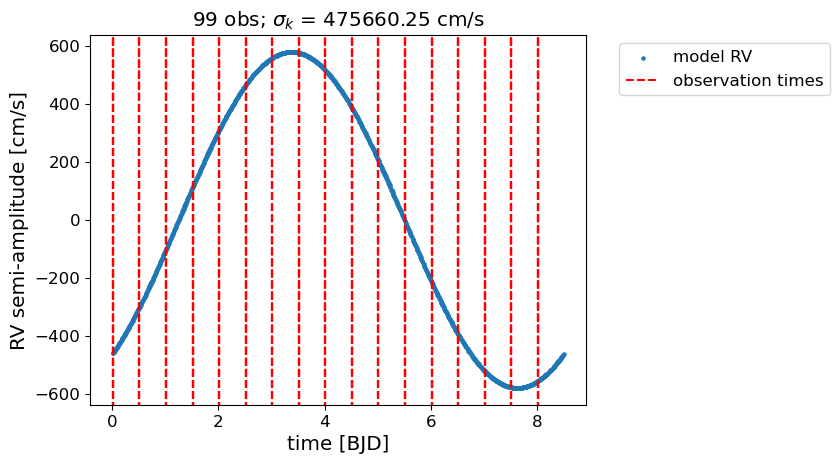

In [27]:
### RV model
start = 2352 # BJD
end = 2552 # BJD
t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
t_phase_folded = t % p
theta = [K, p, T0]
y = calculate_fi.model_jax(t, K, p, T0) # base model
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, K, p, T0))

### sample from GP model and add to base model for more realistic picture
#gp_model = cov_matrix(t_phase_folded, params)
#y_phase_folded = model(t_phase_folded, theta) + gp_model[0]

### plot observations from strategy
strat_phase_folded = np.array(strat) % p

plt.scatter(t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#plt.savefig(f'plots/au-mic/strat1.png', format='png', bbox_inches='tight')
plt.show()

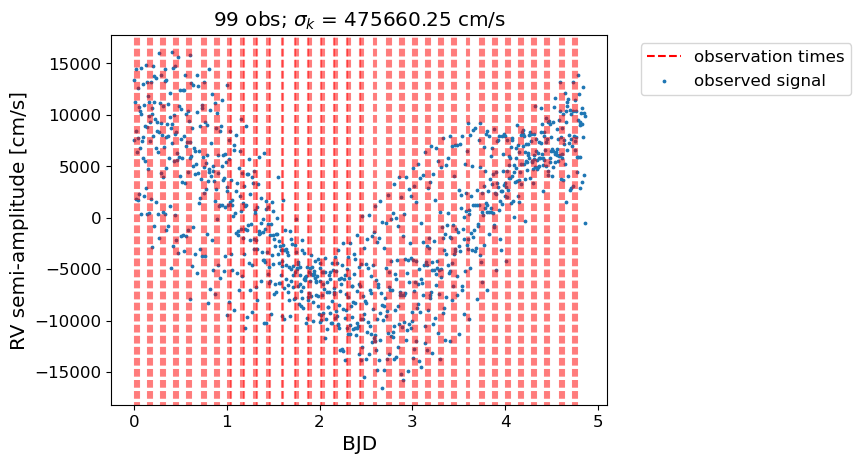

In [29]:
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat:
    plt.axvline(i % Prot, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r', alpha=0.5)
    
specific_sample = sample[0]
#plt.plot(t, y, label='planet signal')
#plt.plot(t, specific_sample, label='stellar signal')
#plt.scatter(t % p, specific_sample + y, label='observed signal', s=3)
#plt.scatter(t[:40] % Prot, specific_sample[:40], label='observed signal', s=3)
plt.scatter(t % Prot, specific_sample, label='observed signal', s=3)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
#plt.xlim([t[0], t[-1]])
#plt.xlim([t[0], t[0]+2*p])
#plt.xlim([2460, 2500])
plt.title(f'{n_obs} obs; ' + r'${\sigma}_k$' + f' = {sigma_k} cm/s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

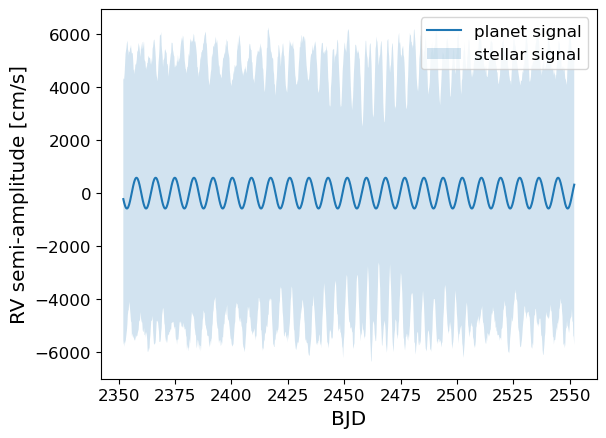

In [24]:
import celerite2
from celerite2 import terms

# quasiperiodic term
#kernel = terms.SHOTerm(sigma=1., rho=1., tau=10.) # S0=1.0, Q=2.5, w0=0.2
kernel = terms.SHOTerm(sigma=sigma_qp_rv, rho=Prot, tau=Tau)

# set up GP
gp = celerite2.GaussianProcess(kernel, mean=0.)
gp.compute(t, yerr=sigma_wn_rv)
sample = gp.sample(size=50)
mu, sigma = np.mean(sample, axis=0), np.std(sample, axis=0)

"""
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
calculate_fi.model_jax(strat, K, p, T0)
"""

plt.plot(t, y, label='planet signal')
plt.fill_between(t, mu - sigma, mu + sigma, alpha=0.2, label='stellar signal')
plt.legend()
plt.xlabel('BJD')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.show()


### Multi-planet case